In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import csv
import os
from torch.utils.data import DataLoader, Dataset

plt.rcParams["figure.figsize"] = (15, 6) # (w, h)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['svg.fonttype'] = 'none'  # 'svgfont'

In [2]:
class VibrationDataset(Dataset):
    def __init__(self, csv_file, inputs=2, outputs=3, samples=0):
        """
        :param csv_file: файл с данными
        :param outputs: число выходных переменных
        :param inputs: число входных переменных
        :param samples: максимальное число отсчетов (0 - все)
        """
        self.inputs = inputs
        self.outputs = outputs
        with open(csv_file, 'r') as f:
            reader = csv.reader(f)  
            # первая строка содержит названия столбцов
            self.header = next(reader, None)
            df = []
            cols = inputs + outputs
            for row in reader:
                if row: # может быть пустая строка в конце
                    df.append([float(x) for x in row[:cols]])
                if samples and len(df) >= samples:
                    break
            self.dataframe = np.array(df)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        # извлечение одной переменной по имени
        if isinstance(idx, str) and idx in self.header:
            return self.dataframe[:,self.header.index(idx)]        
        # извлечение всех значений в заданный момент времени
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return {
            'input': self.dataframe[idx, :self.inputs],
            'output': self.dataframe[idx, self.inputs:]
        }

['Force', 'Voltage', 'Acceleration1', 'Acceleration2', 'Acceleration3', 'Fs', '']


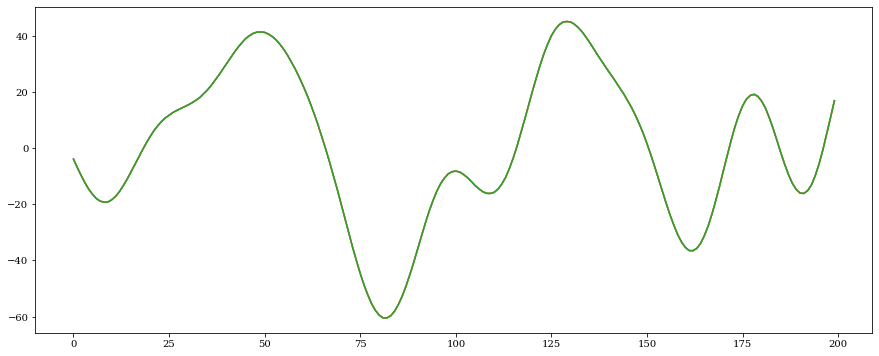

In [3]:
level = 5 # уровни входного воздействия 1 3 5 7
excitation = 'FullMSine' # виды входного воздействия 
# FullMSine SineSw SpecialOddMSine

datadir = 'F16GVT_Files/BenchmarkData'

filename = 'F16Data_{}_Level{}.csv'.format(excitation, level)

filename = 'F16Data_FullMSine_Level2_Validation.csv'


dataset = VibrationDataset(os.path.join(datadir, filename), 2, 3, samples=500)
print(dataset.header)

for epoch in range(3):

    dataloader = DataLoader(dataset, batch_size=200, shuffle=False)

    for i, minibatch in enumerate(dataloader):
        if i == 0:
            plt.plot(minibatch['input'][:,0])

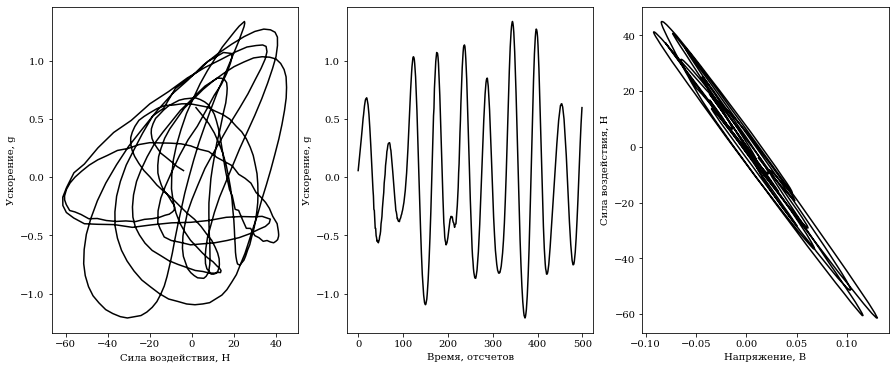

In [4]:
# фазовый портрет вход-выход
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(dataset['Force'], dataset['Acceleration3'], 'k')
ax1.set_xlabel('Сила воздействия, Н')
ax1.set_ylabel('Ускорение, g')

# график процесса на выходе
ax2.plot(dataset['Acceleration3'], 'k')
ax2.set_xlabel('Время, отсчетов')
ax2.set_ylabel('Ускорение, g')

# оценка корреляции между входными переменными
ax3.plot(dataset['Voltage'], dataset['Force'], 'k')
ax3.set_xlabel('Напряжение, В')
ax3.set_ylabel('Сила воздействия, Н')

plt.savefig('рисунок-5-3.svg')
plt.savefig('рисунок-5-3.png')